# 🪐 Spacy


In [4]:
# !python -m spacy download en_core_web_lg
import spacy
from spacy.tokens import Span
from spacy.tokens import DocBin
from spacy import displacy
from spacy.util import filter_spans
from spacy.matcher import PhraseMatcher
import pandas as pd 
import networkx as nx
import matplotlib.pyplot as plt


# Import

In [5]:
import os
import re
import spacy
from spacy.tokens import Doc, Span
from spacy import displacy

nlp = spacy.load("en_core_web_lg")

In [7]:
path = '../'
filename = "C07K.txt"
peptents_text = open(os.path.join(path, filename)).read().strip()
peptents_list = peptents_text.split("\n\n\n") #a list of peptide patents!
#if rereading peptents, delete already_done so that the text can be cleared
try:
    del already_done
except:
    print("Already done doesn't exist anyway")

def check_flawed_peptents(peptents_list):
    """
    Checks that each peptent contains one description and one claim section, not more, nor less.
    Parameters:
        peptents_list: A list of peptents
    Returns:
        descriptionless_peptents, claimless_peptents, doubles: lists of peptent indices which
            - do not contain a description
            - do not contain a claim
            - contain more than one description or claim 
    """
    #find patents without a description
    descriptionless_peptents = []
    claimless_peptents = []
    claims_string = "_____c:"
    descriptions_string = "_____d:"
    doubles = []

    #find all peptents where there is no description, no claim, or duplicates of them
    #this suggests we had a wrong delimiter
    for i,peptent in enumerate(peptents_list):
        description_count = len(re.findall(descriptions_string, peptent))
        claim_count = len(re.findall(claims_string, peptent))
        if description_count == 0:
            descriptionless_peptents.append(i)
        if claim_count == 0:
            claimless_peptents.append(i)
        if description_count > 1:
            print("Found stupid double description peptent at %d" %i)
            doubles.append(i)
        if claim_count > 1:
            print("Found stupid double claim peptent at %d" %i)
            doubles.append(i)      
    return descriptionless_peptents, claimless_peptents, doubles

descriptionless_peptents, claimless_peptents, doubles = check_flawed_peptents(peptents_list)
print("There are %d peptents with more than one description or claim" %len(doubles))
print("Peptent indices without a description:")
print(descriptionless_peptents)
print("Peptent indices without a claim:")
print(claimless_peptents)

Already done doesn't exist anyway
There are 0 peptents with more than one description or claim
Peptent indices without a description:
[180, 1132, 1481, 1482, 1483, 1987]
Peptent indices without a claim:
[180, 1132, 1480, 1481, 1482, 1987]


In [8]:
try: 
    print("Have the peptents been cleaned already?: %s" %already_done)
except:
    print("Cleaning the peptents.")
    #we haven't run this cell yet
    #after some verification, we found the following treatment:
    #drop 180, 1132: empty
    #merge 1483 into 1480: the former is the continuation of the latter
    #drop 1483: merged into 1480
    #drop 1481, 1482, 1987: empty or meaningless code
    peptents_list[1480]+= peptents_list[1483]
    #drop the elements in reverse to not mess with the indices
    peptents_list.pop(1987)
    peptents_list.pop(1483)
    peptents_list.pop(1482)
    peptents_list.pop(1481)
    peptents_list.pop(1132)
    peptents_list.pop(180)

#initialize the varaib
already_done = True

Cleaning the peptents.


In [9]:
descriptionless_peptents, claimless_peptents, doubles = check_flawed_peptents(peptents_list)
count_flawed = len(descriptionless_peptents) + len(claimless_peptents) + len(doubles)
print("Flawed peptents: %d" %count_flawed)

Flawed peptents: 0


# NER 🤗

### ʕ•́ᴥ•̀ʔっ♡ ktgiahieu/RoBERTa-large-PM-M3-Voc-hf-finetuned-ner-combine-filtered

In [10]:
from transformers import (AutoModelForTokenClassification, 
                          AutoTokenizer, 
                          pipeline,
                          )

model_checkpoint = "ktgiahieu/RoBERTa-large-PM-M3-Voc-hf-finetuned-ner-combine-filtered"
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint)                                                        
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

model_pipeline = pipeline(task="ner", model=model, tokenizer=tokenizer)

In [72]:
def get_term_chunks(text):
    orig_entities = model_pipeline(text)

    # Define the ClassLabel feature with the label names
    label_list = ['B-Term','B-Lab_value','B-Chemical','I-Term','I-Lab_value','I-Chemical','O']

    entities = []
    for i in range(len(orig_entities)):
        orig_entities[i]['entity'] = label_list[int(orig_entities[i]['entity'][6:])]
        if orig_entities[i]['entity'] == 'O':
            continue
        entities.append(orig_entities[i])

    # Show the results with highlighting

    from ipymarkup import show_span_ascii_markup, show_dep_ascii_markup, show_span_box_markup

    entities_markup = []
    for i in range(len(entities)):
        if len(entities_markup) == 0:
            # while the previous character is not a space or \n, move the start index back
            while entities[i]['start'] > 0 and text[entities[i]['start']-1] not in [' ', '\n']:
                entities[i]['start'] -= 1
            # while the next character is not a space or punctuation, move the end index forward
            while entities[i]['end'] < len(text) and text[entities[i]['end']] not in [' ', '\n', '.', ',', ';', ':', '!', '?', ')', ']', '}', '>', '"', "'", '”', '’', '‘', '›', '»']:
                entities[i]['end'] += 1
            entities_markup.append([entities[i]['start'], entities[i]['end'], entities[i]['entity'][2:]])
            continue
        if (entities[i]['start'] <= entities[i-1]['end'] \
            or entities[i]['start'] <= entities[i-1]['end']+1 \
            # or entities[i]['start'] <= entities[i-1]['end']+2 \
            # or entities[i]['start'] <= entities[i-1]['end']+3 \
        ) and \
            (entities[i]['entity'][2:] == entities[i-1]['entity'][2:] \
             or (entities[i]['entity'][2:] in ['Term', 'Chemical'] and entities[i-1]['entity'][2:] in ['Term', 'Chemical'])):
            # while the next character is not a space or punctuation, move the end index forward
            while entities[i]['end'] < len(text) and text[entities[i]['end']] not in [' ', '\n', '.', ',', ';', ':', '!', '?', ')', ']', '}', '>', '"', "'", '”', '’', '‘', '›', '»']:
                entities[i]['end'] += 1
            entities_markup[-1][1] = entities[i]['end']
        else:
            # while the previous character is not a space or \n, move the start index back
            while entities[i]['start'] > 0 and text[entities[i]['start']-1] not in [' ', '\n']:
                entities[i]['start'] -= 1
            # while the next character is not a space or punctuation, move the end index forward
            while entities[i]['end'] < len(text) and text[entities[i]['end']] not in [' ', '\n', '.', ',', ';', ':', '!', '?', ')', ']', '}', '>', '"', "'", '”', '’', '‘', '›', '»']:
                entities[i]['end'] += 1
            entities_markup.append([entities[i]['start'], entities[i]['end'], entities[i]['entity'][2:]])

    term_chunks = [{
        'start': chunk[0],
        'end': chunk[1],
        'label': chunk[2],
        'text': cleanNshort[chunk[0]:chunk[1]]
    }
        for chunk in entities_markup
    ]
    return term_chunks

In [80]:
cleanNshort = '\n'.join(peptents_list[2].split("_____d:")[1].split("_____c:")[0].split("\n")[1:5])
term_chunks = get_term_chunks(cleanNshort)

doc = nlp(cleanNshort)


displacy.render({'text': cleanNshort, 'ents': term_chunks, 'title': None},
                style='ent', manual=True, jupyter=True)

### adding the predicates

In [81]:
def get_predicates_between_term_chunks(doc, term_chunks):
    predicates = []
    sources = []
    targets = []

    for i in range(len(term_chunks) - 1):
        start_chunk_token = doc.char_span(
            term_chunks[i]['start'], term_chunks[i]['end'])
        end_chunk_token = doc.char_span(
            term_chunks[i + 1]['start'], term_chunks[i + 1]['end'])
        
        if start_chunk_token is None or end_chunk_token is None or start_chunk_token.sent != end_chunk_token.sent:
            continue

        # Find the shortest path between the root tokens of the neighboring noun chunks
        start_token = start_chunk_token.root
        end_token = end_chunk_token.root

        # not ideal, can possibly be shortened:
        predicate_tokens = []
        if start_token in end_token.ancestors:
            ancs = end_token.ancestors
            stop = start_token
        elif end_token in start_token.ancestors:
            ancs = start_token.ancestors
            stop = end_token
        else:
            for token in end_token.ancestors:
                predicate_tokens.append(token)
                if token in end_token.ancestors:
                    break
            ancs = end_token.ancestors
            stop = token
        for tok in ancs:
            if tok == stop:
                break
            predicate_tokens += [tok]
    

        if not predicate_tokens:
            continue
        predicate_tokens = sorted(
            predicate_tokens, key=lambda token: token.i)
        predicate_text = ' '.join(token.text for token in predicate_tokens)
        start_char = predicate_tokens[0].idx
        end_char = start_char + len(predicate_text)
        
        predicates.append({
            'start': start_char,
            'end': end_char,
            'label': 'PRED',
            'text': predicate_text
        })
        sources += [start_chunk_token]
        targets += [end_chunk_token]
        # print(
        #     f'{predicate_text} :: {start_chunk_token} _______ { end_chunk_token}')

    return predicates, sources, targets


# text = "The model that is presented in FIGS 1 and 2 shows a data center cooling configuration that can include a chilled water system app with ice that must not include strawberries. The strawberries choke the said chilled water system app that is included in the model."
text = cleanNshort
# text = "the said data center cooling configuration that is included in the model."
doc = nlp(text)
displacy.render(doc, style="dep")
term_chunks = get_term_chunks(text)
predicates, sources, targets = get_predicates_between_term_chunks(
    doc, term_chunks)

funkycolor = "linear-gradient(90deg, #aa9cfc, #fc9ce7)"
displacy.render({'text': text, 'ents': term_chunks + predicates,
                'title': None}, style='ent', manual=True, jupyter=True, options={'colors': {"PRED": funkycolor}})


### a representation of the semantic graph

inspired by https://www.kaggle.com/code/cananserper/knowledge-graph-spacy  

In [82]:
df = pd.DataFrame({'source': [str(s) for s in sources], 'target': [str(t) for t in targets], 'edge': [r['text'] for r in predicates]})
df

,source,target,edge
0,fusion proteins,peptide linker,to
1,peptide linker,fusion proteins,for construction of
2,protein fusion technology,bifunctional antibodies,of
3,fusion protein,active site,blocked
4,active site,fused proteins,between
5,fused proteins,fusion protein,molecule
6,fusion protein,proteases,by
7,proteases,protein catalytic domain,loses
8,protein,fusion protein,in
9,fusion protein,protein molecule(s,of


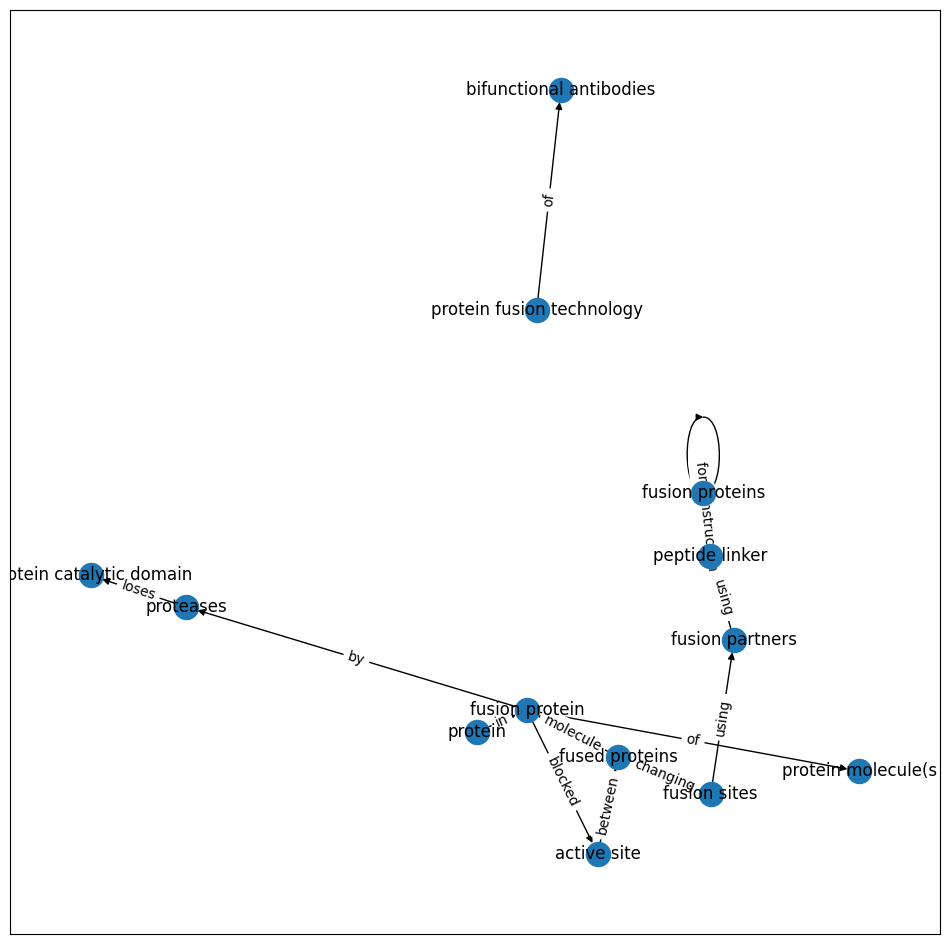

In [84]:
G = nx.from_pandas_edgelist(df, "source", "target",
                            edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G)
nx.draw_networkx(G, with_labels=True, pos=pos)

# Add edge labels
edge_labels = {(row['source'], row['target']): row['edge']
               for _, row in df.iterrows()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()


In [87]:
print(cleanNshort)
doc=nlp(cleanNshort)
# displacy.render(doc, style="dep")
term_chunks = get_term_chunks(cleanNshort)
predicates, sources, targets = get_predicates_between_term_chunks(
    doc, term_chunks)

displacy.render({'text': cleanNshort, 'ents': term_chunks + predicates,
                'title': None}, style='ent', manual=True, jupyter=True, options={'colors': {"PRED": funkycolor}})


FIELD OF THE INVENTION
The present invention relates to the field of fusion proteins and, more specifically, to a peptide linker for the construction of fusion proteins.
BACKGROUND
In recent two decades, protein fusion technology has been widely used in the construction of bifunctional antibodies, bifunctional enzymes, and bifunctional proteins. However, a variety of problems have been encountered in the construction of fusion proteins. For example, proteins that fold correctly during expression alone do not fold properly in the fusion protein; the active site is blocked after fusion due to the short distance between the two fused proteins; the fusion protein molecule is easily degraded by proteases when it cannot fold properly or when its conformation has changed; the protein catalytic domain with certain flexibility loses its original function after fusion; and so on. The emergence of these problems often leads to reduction or even complete loss of the activity of the fusion proteins

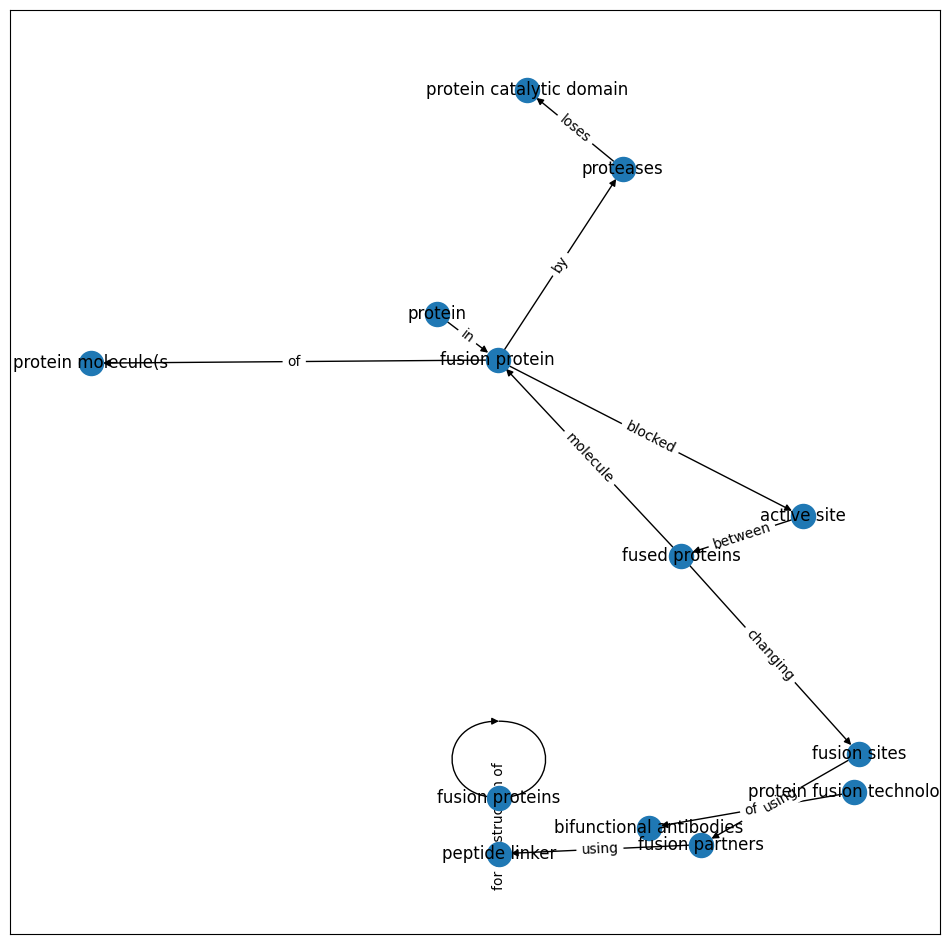

In [89]:
df = pd.DataFrame({'source': [str(s) for s in sources], 
                    'target': [str(t) for t in targets], 
                    'edge': [r['text'] for r in predicates]})

G = nx.from_pandas_edgelist(df, "source", "target",
                            edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G)
nx.draw_networkx(G, with_labels=True, pos=pos)

# Add edge labels
edge_labels = {(row['source'], row['target']): row['edge']
               for _, row in df.iterrows()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()


#### find errors

#### ideas
- make a matrix of relations between all NC in a sentence and choose the best ones
- handle coordinations
- ternary relations work?
- better parser: Trankit?
- text preparation to improve results
	- "said"
	- past participles into "that is pp" (no past tense in patents?)
- coreference resolution
- negation
- special treatment for non-connected graphs
- nice inline visualization



### work with Prodigy

goal
- train spacy models for the extraction of relations
- find alternative
- compare

https://support.prodi.gy/t/beta-testers-wanted-new-manual-dependencies-relations-ui-v1-10/2893